# Solving CartPole using Deep Q-Learning

Let's start by installing OpenAI Gym in order to get the CartPole environment

In [1]:
!pip install gym

Now to load all the packages we need

In [2]:
import gym
import numpy as np
import random
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Deep Q-Learning Agent

The DQNAgent class is going to house all the logic necessary to have a Deep Q-Learning Agent. Since there's a lot going on here, this section will be longer than the others.

### Parameters

There are several parameters that are hard-coded into the model that should be tweaked when applying it to different problems to see if it affects performance. We will describe each parameter briefly here.



* Epsilon: The exploration rate. How often will the agent choose a random move during training instead of relying on information it already has. Helps the agent go down paths it normally wouldn't in hopes for higher long term rewards.
  - Epsilon Decay: How much our epsilon decreases after each update
  - Epsilon Min: The lowest rate of exploration we'll allow during training
* Gamma: Discount rate. This tells us how much we prioritize current versus future rewards.
* Tau: Affects how much we shift our knowledge based off of new information.
* Learning Rate: Affects the optimization procedures in the neural networks.



### Fixed Q-Targets

In Q-Learning we update our Q_Table through the following function:

$Q_{TableEntry}(state, action) = Reward + max(Q_{TableEntry}(state))$

Since our update is dependent on the same table itself, we can start to get correlated entries. This could cause oscillations to happen in our training. 

To combat this, we implemented a target model. It essentially is a copy of the original model, except that the values do not update as rapidly. The rate at which the target model updates is dependent upon `Tau` in our parameter list.

### Agent Workflow

1. Create an empty neural network for both the model and target model.
2. Given a starting state, perform an action.
3. Once you performed the action on the environment, store the information gained into the agent's memory.
4. Once the agent acquires enough memory to meet the batch size requirements, select `batch_size` number of past memories randomly and train the model on those experiences.
5. The model will be trained by calculating the value of the current state and  updating the value proposed previously by the model.
6. The value of the state.
  - If the game is finished, then the reward is the value of that state.
  - If not, then take the current reward and add the discounted reward of future states.
7. Decay the epsilon value as described in the parameters.
8. Gradually update the target model.
9. Perform an action for the new state, either randomly through epsilon, or by choosing the best action based on what we currently know.
9. Repeat steps 4-9.

In [0]:
class DQNAgent:
  def __init__(self, state_size, action_size):
    self.state_size = state_size
    self.action_size = action_size
    # The deque will only contain the last 2000 entries
    self.memory = deque(maxlen=2000)
    self.gamma = 0.95 # Discount Rate
    self.epsilon = 1.0 # Exploration Rate
    self.epsilon_min = 0.001
    self.epsilon_decay = 0.9995
    self.learning_rate = 0.001
    self.model = self._build_model()
    ## Additional components for Fixed Q-Targets
    self.target_model = self._build_model()
    self.tau = 0.1 # We want to adjust our network by 10% each time
    
  def _build_model(self):
    model = Sequential()
    model.add(LSTM(24, batch_input_shape=(1, 1, self.state_size), activation='tanh', recurrent_activation='hard_sigmoid'))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(self.action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
    return model
  
  def update_target_model(self):
    for layer_target, layer_src in zip(self.target_model.layers, self.model.layers):
      weights = layer_src.get_weights()
      target_weights = layer_target.get_weights()
      # Adjust the weights of the target to be tau proportion closer to the current
      for i in range(len(weights)):
            target_weights[i] = self.tau * weights[i] + (1 - self.tau) * target_weights[i]
      layer_target.set_weights(target_weights)
  
  def remember(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
    
  def act_random(self):
    return random.randrange(self.action_size)
  
  def best_act(self, state):
    # Choose the best action based on what we already know
    # If all the action values for a given state is the same, then act randomly
    action_values = self.target_model.predict(state)[0]
    action = self.act_random() if np.all(action_values[0] == action_values) else np.argmax(action_values)
    return action
  
  def act(self, state):
    action = self.act_random() if np.random.rand() <= self.epsilon else self.best_act(state)
    if self.epsilon > self.epsilon_min:
      self.epsilon *= self.epsilon_decay
    return action
  
  def replay(self, batch_size):
    minibatch = random.sample(self.memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
      target = reward
      if not done:
        target = reward + self.gamma * np.amax(self.target_model.predict(next_state)[0])
      action_values = self.target_model.predict(state)
      action_values[0][action] = target
      self.model.fit(state, action_values, epochs=1, verbose=0)
    
    self.update_target_model()

      
  
  def load(self, name):
    self.model.load_weights(name)
    
  def save(self, name):
    self.model.save_weights(name)

## Training

We will now use our Deep Q-Learning Agent to train it in CartPole by simulating a lot of runs through the environment.

In [4]:
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = DQNAgent(state_size, action_size)
done = False
batch_size = 32
EPISODES = 50

for episode_num in range(EPISODES):
  state = env.reset()
  state = np.reshape(state, [1, 1, state_size])
  
  time = 0
  done = False
  while not done:
    action = agent.act(state)
    next_state, reward, done, _ = env.step(action)
    
    reward = reward if not done else -10
    next_state = np.reshape(next_state, [1, 1, state_size])
    
    agent.remember(state, action, reward, next_state, done)
    
    state = next_state
    
    if done:
      print("episode: {}/{}, score: {}, epsilon: {:.2}"
          .format(episode_num, EPISODES, time, agent.epsilon))
      break # We finished this episode
    
    if len(agent.memory) > batch_size:
      agent.replay(batch_size)
    
    time += 1
  

/usr/local/lib/python3.6/dist-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


episode: 0/50, score: 11, epsilon: 0.99
episode: 1/50, score: 32, epsilon: 0.98
episode: 2/50, score: 7, epsilon: 0.97
episode: 3/50, score: 20, epsilon: 0.96
episode: 4/50, score: 11, epsilon: 0.96
episode: 5/50, score: 10, epsilon: 0.95
episode: 6/50, score: 19, epsilon: 0.94
episode: 7/50, score: 15, epsilon: 0.94
episode: 8/50, score: 46, epsilon: 0.91
episode: 9/50, score: 27, epsilon: 0.9
episode: 10/50, score: 80, epsilon: 0.87
episode: 11/50, score: 15, epsilon: 0.86
episode: 12/50, score: 11, epsilon: 0.85
episode: 13/50, score: 14, epsilon: 0.85
episode: 14/50, score: 26, epsilon: 0.84
episode: 15/50, score: 29, epsilon: 0.82
episode: 16/50, score: 15, epsilon: 0.82
episode: 17/50, score: 9, epsilon: 0.81
episode: 18/50, score: 24, epsilon: 0.8
episode: 19/50, score: 48, epsilon: 0.78
episode: 20/50, score: 11, epsilon: 0.78
episode: 21/50, score: 31, epsilon: 0.77
episode: 22/50, score: 23, epsilon: 0.76
episode: 23/50, score: 24, epsilon: 0.75
episode: 24/50, score: 20, eps

## Evaluate Performance

Now to test how our agent performed, we will run through more scenarios except this time we don't allow the agent to choose randomly and have it rely on its previous experiences.

In [5]:
time_achieved = []
for episode_num in range(EPISODES):
  state = env.reset()
  state = np.reshape(state, [1, 1, state_size])
  
  time = 0
  done = False
  while not done:
    action = agent.best_act(state)
    next_state, reward, done, _ = env.step(action)
    
    reward = reward if not done else -10
    next_state = np.reshape(next_state, [1, 1, state_size])
    
    
    state = next_state
    
    if done:
      print("episode: {}/{}, score: {}"
          .format(episode_num, EPISODES, time))
      time_achieved.append(time)
      break # We finished this episode

    time += 1
  

episode: 0/50, score: 214
episode: 1/50, score: 187
episode: 2/50, score: 177
episode: 3/50, score: 174
episode: 4/50, score: 215
episode: 5/50, score: 188
episode: 6/50, score: 152
episode: 7/50, score: 186
episode: 8/50, score: 154
episode: 9/50, score: 180
episode: 10/50, score: 214
episode: 11/50, score: 197
episode: 12/50, score: 152
episode: 13/50, score: 196
episode: 14/50, score: 174
episode: 15/50, score: 169
episode: 16/50, score: 153
episode: 17/50, score: 162
episode: 18/50, score: 163
episode: 19/50, score: 160
episode: 20/50, score: 189
episode: 21/50, score: 218
episode: 22/50, score: 162
episode: 23/50, score: 174
episode: 24/50, score: 200
episode: 25/50, score: 163
episode: 26/50, score: 235
episode: 27/50, score: 196
episode: 28/50, score: 191
episode: 29/50, score: 167
episode: 30/50, score: 191
episode: 31/50, score: 158
episode: 32/50, score: 155
episode: 33/50, score: 182
episode: 34/50, score: 212
episode: 35/50, score: 182
episode: 36/50, score: 186
episode: 37

## Analysis of Performance

Let us load the pandas library to have some visualizations


In [0]:
import pandas as pd

In [0]:
time_achieved = pd.DataFrame(time_achieved, columns = ['time'])

Now to display a histogram of seconds that we lasted.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6e9d717fd0>]],
      dtype=object)

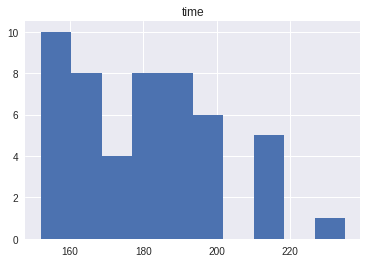

In [8]:
time_achieved.hist()

Summary Statistics for summarization

In [9]:
print("Mean: {} seconds\nStandard Deviation: {} seconds".format(time_achieved.time.mean(), time_achieved.time.std()))

Mean: 179.96 seconds
Standard Deviation: 20.087522779789733 seconds
